In [57]:
from qiskit import QuantumCircuit, transpile
import numpy as np
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import Statevector, state_fidelity
from scipy.linalg import expm
import matplotlib.pyplot as plt

##### First we define some helping functions

In [36]:
# flattening functions to go from 2d lattice point to qubit number in the way i texted in the group about
def lattice_to_qubit(i, j, N):
    if i%2 == 0:
        return i*N + j
    else:
        return i*N + N -j -1

# inverse transformation
def qubit_to_lattice(q, N):
    # Calculate the row (i) and column (j) in the lattice
    i = q // N  # Integer division to get the row
    if i % 2 == 0:
        # For even rows, the qubit index increases left to right
        j = q % N
    else:
        # For odd rows, the qubit index increases right to left
        j = N - (q % N) - 1
    return i, j

# function to get neighbors of given point in qubit index
def get_neighbors(i, j, N):
    neighbors = []
    
    # Check top neighbor (i-1, j)
    if i - 1 >= 0:
        neighbors.append(lattice_to_qubit(i - 1, j, N))
    
    # Check bottom neighbor (i+1, j)
    if i + 1 < N:
        neighbors.append(lattice_to_qubit(i + 1, j, N))
    
    # Check left neighbor (i, j-1)
    if j - 1 >= 0:
        neighbors.append(lattice_to_qubit(i, j - 1, N))
    
    # Check right neighbor (i, j+1)
    if j + 1 < N:
        neighbors.append(lattice_to_qubit(i, j + 1, N))
    
    return neighbors

# function to get the commuting groups for the W operator
def find_groups(lattice_size):
    # List to store groups of nearest neighbors
    groups = [[], [], [], []]
    
    # Iterate over all lattice points
    for x in range(lattice_size):
        for y in range(lattice_size):
            # Determine the parity of x and y
            parity_x = x % 2
            parity_y = y % 2
            
            # Find the right neighboring points (right and up)
            if x + 1 < lattice_size:  # Right neighbor
                if  parity_x == 0:
                    groups[0].append(([x, y], [x + 1, y]))
                else:
                    groups[1].append(([x, y], [x + 1, y]))
            
            if y+1 < lattice_size:  # Up neighbor
                if parity_y == 0:
                    groups[2].append(([x, y], [x, y + 1]))
                else:
                    groups[3].append(([x, y], [x, y + 1]))
    
    # Return the groups ordered by your specified parity rule
    return groups


# digital gate trotterization of the W operator
def W(qc, N, t, M, J_matrix, g_matrix):
    for _ in range(M):
        # applying the Z rotation
        for i in range(N):
            for j in range(N):
                q = lattice_to_qubit(i, j, N) 
                qc.rz(J_matrix[i,j] * t / M, q +1)
        # applying the XX and YY rotations
        groups = find_groups(N)
        for group in groups:
            if group == []:
                continue
            for pairs in group:
                q1 = lattice_to_qubit(pairs[0][0], pairs[0][1], N) 
                q2 = lattice_to_qubit(pairs[1][0], pairs[1][1], N) 
                angle = g_matrix[q1, q2] * t / (2*M)
                qc.rxx(angle, q1 +1, q2 +1)
                qc.ryy(angle, q1+1, q2+1)


In [46]:
# defining pauli matrices
I = np.eye(2)
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

# function for pauli chain with I and X in indexed spots
def xixj(index1,index2,N):
    if index1 == 0 or index2 == 0:
        result = X
    else:
        result = I
    for i in range(1,N):
        if i == index1 or i == index2:
            result = np.kron(result,X)
        else:
            result = np.kron(result, I)
    return result

# function for pauli chain with I and Y in indexed spots
def yiyj(index1,index2,N):
    if index1 == 0 or index2 == 0:
        result = Y
    else:
        result = I
    for i in range(1,N):
        if i == index1 or i == index2:
            result = np.kron(result,Y)
        else:
            result = np.kron(result, I)
    return result

# function for pauli chain with I and Z in indexed spot
def zi(index,N):
    if index == 0:
        result = Z
    else:
        result = I
    for i in range(1,N):
        if i == index:
            result = np.kron(result,Z)
        else:
            result = np.kron(result, I)
    return result

# making a function for the XY model hamiltonian H
def Hamiltonian_unitary(J_matrix, g_matrix,N):
    H = np.zeros((2**(N**2), 2**(N**2)), dtype=np.complex128)
    interaction_count = [] # keeping track of pairs to only ocunt once
    for i in range(N):
        H += J_matrix[qubit_to_lattice(i,N)]*zi(i,N**2) # adding onsite potential
        for j in range(N):
            neighbors = get_neighbors(i,j, N) # getting nearest neighbors without periodic boundaries
            for neighbor in neighbors:
                q1 = lattice_to_qubit(i, j, N) # mapping to qubits with chessboard pattern
                q2 = neighbor
                if (q1,q2) not in interaction_count: # checking if the pair has already been counted
                    H += g_matrix[q1, q2]*xixj(q1,q2,N**2)/2 # applying the X term
                    H += g_matrix[q1, q2]*yiyj(q1,q2,N**2)/2 # applying the Y term
                    interaction_count.append((q2,q1))
    print(interaction_count)
    return H


def Ham_evo(H, t):
    if t%2 == 0: # to ensure alternatiion between W(1/2) and W(-1/2)
        op = Operator(expm(-1j*H/2))
        op.label = "W(1/2)"
        return op
    else:
        op = Operator(expm(1j*H/2))
        op.label = "W(-1/2)"
        return op
    


N = 2
J_test = np.random.rand(N,N)
G_test = np.random.rand(N**2,N**2)

J_test = 0*np.ones((N,N))
G_test = 2*np.ones((N**2,N**2))

H = Hamiltonian_unitary(J_test, G_test, N)
print(H)

diag = np.linalg.eigvalsh(H)
print(np.round(diag,2))


[(3, 0), (1, 0), (2, 1), (2, 3)]
[[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
  0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 2.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 2.+0.j 0.+0.j
  0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 2.+0.j 0.+0.j 0.+0.j 2.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
  0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 2.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
  2.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 2.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 2.+0.j 0.+0.j
  0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 2.+0.j 0.+0.j 0.+0.j 2.+0.j 0.+0.j 0.+0.j 2.+0.j
  0.+0.j 0.+0.j 2.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 2.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
  2.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
  0.+0.j 2.+0.j 0.+0.j 0.+0.j 2.+0.j 0.+0.j]
 [0.+0.j 2.+0.j 0.+0.j 0.+0.j 2

#### Comments on this so far

We do a $N^2 +1$ qubit circuit, because we have the one control and a $N^2$ qubit hamiltonian, because each qubit models one spin site.
Then we apply the phases first in order.
There is a problem with the K-string: Since we have nearest neighbor terms and i flatten the NxN lattice to $N^2$ qubits with the formula i defined above. This only works for even values sidelength of the system we are trying to simulate though as there otherwise wont be a mapping to ensure all nearest neighbors are of different parity (i think).

Rn i am not sure if the order $K (W^{t/M})^M K$ is correct or if there are supposed to be some K's in between the trotter steps as well.

In [4]:
def analog_qetu(phi, N, H):
    # creating a quantum circuit with NxN qubits and one ancilla qubit
    qc = QuantumCircuit(N**2 + 1)
    
    for i in range(len(phi)-1):
        # applying the x rotation by the phase to the ancilla qubit
        qc.rx(phi[i], 0)

        # applying the controlled K string of pauli operators
        for i in range(int(N**2)): 
            if i%2 == 0:
                qc.cx(0, i+1)
            if i%2 == 1:
                qc.cy(0, i+1)
        
        # applying the hamiltonian evolution
        qc.append(Ham_evo(H, i), range(1,N**2+1))
        
        # applying the k-string again

        for i in range(int(N**2)):
            if i%2 == 0:
                qc.cx(0, i+1)
            if i%2 == 1:
                qc.cy(0, i+1)
        
    # applying the last x rotation
    qc.rx(phi[-1], 0)

    return qc

def digital_qetu(phi, N, t, M, J_matrix, g_matrix):
    # creating a quantum circuit with NxN qubits and one ancilla qubit
    qc = QuantumCircuit(N**2 + 1)
    
    for i in range(len(phi)-1):
        # applying the x rotation by the phase to the ancilla qubit
        qc.rx(phi[i], 0)

        # applying the controlled K string of pauli operators
        for i in range(int(N**2)): 
            if i%2 == 0:
                qc.cx(0, i+1)
            if i%2 == 1:
                qc.cy(0, i+1)

        qc.barrier()
        
        # applying the hamiltonian evolution
        W(qc, N, t, M, J_matrix, g_matrix)

        qc.barrier()
        
        # applying the k-string again

        for i in range(int(N**2)):
            if i%2 == 0:
                qc.cx(0, i+1)
            if i%2 == 1:
                qc.cy(0, i+1)
        
    # applying the last x rotation
    qc.rx(phi[-1], 0)

    return qc


<IPython.core.display.Latex object>

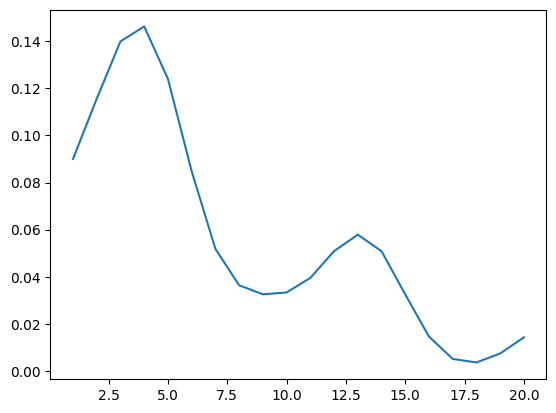

In [60]:
t = 1
M = 2
# digital implementation
N = 2
qc = QuantumCircuit(N**2+1)
for i in range(1, N**2 +1):
    qc.h(i)
qc.unitary(Ham_evo(H,0), range(N**2))
state = Statevector.from_instruction(qc)

# analog implementation
fidelities = []
qc2 = QuantumCircuit(N**2+1)
for i in range(1, N**2 +1):
    qc2.h(i)
for i in range(20):
    W(qc2, N, t, i, J_test, G_test)
    state2 = Statevector.from_instruction(qc2)
    fidelities.append(state_fidelity(state, state2))

plt.plot(np.linspace(1,20,20), fidelities)




we dont really approach 1, so it seems like the dynamics of the current trotter and analog implementations are different from each other

In [56]:
qc = QuantumCircuit(2)
qc.unitary(Operator(expm(-1j*np.pi/4*(xixj(0,1,2) + yiyj(0,1,2) ))), [0,1])
state = Statevector.from_instruction(qc)
state.draw('latex')

<IPython.core.display.Latex object>

In [52]:
qc = QuantumCircuit(2)
qc.rxx(np.pi/2, 0,1)
qc.ryy(np.pi/2, 0,1)
state = Statevector.from_instruction(qc)
state.draw('latex')

<IPython.core.display.Latex object>